# Request Type
Command vs Question

In [1]:
import pandas as pd
import sqlite3
import os
import numpy as np


from helpers.normalization import remove_punctuation, remove_punctuation_and_newlines, remove_newlines
from helpers.statistical_tests import run_t_test_on_gender, compare_genders

# db_path = "../../giicg.db"
# if not os.path.exists(db_path):
#     raise FileNotFoundError(f"Database file does not exist: {db_path}")
#
# conn = sqlite3.connect(db_path)
# prompts = pd.read_sql("SELECT ep.*, u.age, u.work_exp_years FROM expanded_prompts ep JOIN users u ON ep.user_id = u.user_id", conn)
# prompts['conversational'] = prompts['conversational'].apply(remove_newlines)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set up LLM

In [2]:
# from langchain_openai import ChatOpenAI
# from dotenv import load_dotenv
# from pydantic import BaseModel, Field
# from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate
#
# load_dotenv()
#
# class OutputFormat(BaseModel):
#     can_you_q: bool = Field(description="True, if the prompt is a 'can you' question")
#     how_to_q: bool = Field(description="True, if the prompt is a 'how to' question")
#     i_want: bool = Field(description="True, if the prompt is a 'i want' request")
#     descriptive: bool = Field(description="True, if the prompt is a descriptive request")
#     command: bool = Field(description="True, if the prompt is a command")
#     comment: bool = Field(description="True, if the prompt is a comment of the output")
#     other: bool = Field(description="True, if the prompt is neither of the categories")
#
# system_prompt = SystemMessagePromptTemplate.from_template(
#     "You are an assistant that helps categorize prompts."
# )
#
# user_prompt = HumanMessagePromptTemplate.from_template(
#     """
#     You are tasked with categorizing prompts into seven categories. The prompt is here for you to examine:
#     ---
#     {prompt}
#     ---
#     The prompt can belong into either of the following categories:
#     1. Can-you-question: The user asks the llm to to a task by saying "Can you do xyz"
#     2. How-to-question: The user asks the llm how a thing can be achieved by saying "How to xyz"
#     3. I-want-request: The user asks the llm to do a task by saying "I want xyz"
#     4. Descriptive: The user asks the llm to do a task by describing the desired output (e.g "The bar plot should have blue bars").
#     5. Command: The user asks the llm to do a task by saying "Do xyz"
#     6. Comment: The user comments on the previous output in a positive or negative manner (e.g "Cool", "This doesn't work").
#     7. Other: The prompt fits neither of the above categories.
#
#     A prompt may have aspects of multiple categories, for example: "Cool, can you also add xyz"
#     Set all corresponding output fields to true.
#     """,
#
# input_variables=["prompt"]
# )
#
# complete_prompt = ChatPromptTemplate.from_messages([system_prompt, user_prompt])
#
# def categorize_prompt(prompt):
#     OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
#     openai_model = "gpt-4o"
#     llm = ChatOpenAI(temperature=0.0, model=openai_model)
#     structured_llm = llm.with_structured_output(OutputFormat)
#
#     print(f"evaluating next prompt")
#     chain_one = (
#             {"prompt": lambda x: x["prompt"]}
#             | complete_prompt
#             | structured_llm
#             | {"can_you_q": lambda x: x.can_you_q,
#                "how_to_q": lambda x: x.how_to_q,
#                "i_want": lambda x: x.i_want,
#                "descriptive": lambda x: x.descriptive,
#                "command": lambda x: x.command,
#                "comment": lambda x: x.comment,
#                "other": lambda x: x.other,
#                }
#     )
#
#     response =  chain_one.invoke({"prompt": prompt})
#
#     return response["can_you_q"], response["how_to_q"], response["i_want"], response["descriptive"], response["command"], response["comment"], response["other"]

In [3]:
# prompts[['can_you_q', 'how_to_q', 'i_want', 'descriptive', 'command', 'comment', 'other']] = prompts['conversational'].apply(lambda x: pd.Series(categorize_prompt(x)))
#
# prompts

## Save to Database

In [4]:
# prompts.to_sql('categorized_prompts', conn, if_exists='replace', index=False)

## Helpers

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
import seaborn as sns
from helpers.occurences import count_occurrences
import pandas as pd
import sqlite3
from helpers.statistical_tests import compare_genders


def count(df, group_name, word_types, word_lists):
    for word_type, word_list in zip(word_types, word_lists):
        for word in word_list:
            df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
        df[word_type] = df[word_list].sum(axis=1)
    df[group_name] = df[word_types].sum(axis=1)
    return df

gender_palette = {'Woman (cisgender)': 'red', 'Man (cisgender)': 'blue'}
age_palette = {'19-25': 'red', '26-30': 'orange', '31-35': 'yellow', '36-40': 'green', '41-50': 'blue', '51-60': 'purple'}


def box_plot(df, id_vars, bar_variables, x_tick_labels, x_label, y_label, hue_variable, palette):
    melted = df.melt(
    id_vars=id_vars,
    value_vars=bar_variables,
    var_name=x_label,
    value_name=y_label
)

    plt.figure(figsize=(8,6))
    sns.boxplot(
        data=melted,
        x=x_label,
        y=y_label,
        hue=hue_variable,
        palette=palette,
        width=0.7
    )

    plt.title(f'Request Type by {hue_variable}')
    plt.ylabel('Average Proportion of Prompts')
    plt.xlabel('Score/Count')
    plt.legend(title=hue_variable)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.xticks(
        ticks=range(len(x_tick_labels)),
        labels=x_tick_labels,
        rotation=45
    )


    plt.show()


def groupwise_comparison_with_correction(df, columns, one_sided=False, direction="greater"):
    stat_vals = []
    dfs= []
    p_vals = []
    test_types = []
    directions = []
    one_sideds = []
    female_means = []
    male_means = []
    female_stds = []
    male_stds = []
    n_females = []
    n_males = []
    nonzero_females = []
    nonzero_males = []
    effsizes = []
    effsize_types = []
    cis = []
    for col in columns:
        result = compare_genders(df, col, one_sided=one_sided, direction=direction)
        stat_vals.append(result['test_statistic'])
        dfs.append(result['df'])
        p_vals.append(result['p_value'])
        test_types.append(result['test_type'])
        directions.append(result['direction'])
        one_sideds.append(result['one_sided'])
        female_means.append(result['m_female'])
        male_means.append(result['m_male'])
        female_stds.append(result['std_female'])
        male_stds.append(result['std_male'])
        n_females.append(result['n_female'])
        n_males.append(result['n_male'])
        nonzero_females.append(result['hits_female'])
        nonzero_males.append(result['hits_male']),
        effsizes.append(result['effect_size']),
        effsize_types.append(result['effect_size_type'])
        cis.append(result['effect_size_CI'])
    reject, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    results = pd.DataFrame({
        'word': columns,
        'test type': test_types,
        'direction': directions,
        'one_sided': one_sideds,
        'df': dfs,
        'stat_value': stat_vals,
        'p_value': p_vals,
        'corrected p_value': pvals_corrected,
        'mean_f': female_means,
        'mean_m': male_means,
        'std_f': female_stds,
        'std_m': male_stds,
        'n_f': n_females,
        'n_m': n_males,
        'n_hits_f': nonzero_females,
        'n_hits_m': nonzero_males,
        'effsize': effsizes,
        'effsize_type': effsize_types,
        'ci': cis,
    })
    return results

def compute_anova(df, id_vars, value_vars, x_label, y_label):
    melted = df.melt(
    id_vars=id_vars,
    value_vars=value_vars,
    var_name=x_label,
    value_name=y_label
    )

    model = ols(f'{y_label} ~ gender * {x_label}', data=melted).fit()
    return sm.stats.anova_lm(model, typ=2)


## Reimport

In [6]:
db_path = "../../giicg.db"
conn = sqlite3.connect(db_path)
prompts = pd.read_sql("SELECT * FROM categorized_prompts", conn)
prompts

,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,age,...,we_question,boosters,greetings,anger,joy,neutral,please,thanks,surprise,scepticism
0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,0,Man (cisgender),6,19-25,...,0,0,0,0,0,1,0,0,0,0
1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,0,Man (cisgender),6,19-25,...,0,0,0,0,0,1,0,0,0,0
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,0,Man (cisgender),6,19-25,...,0,0,0,0,0,1,0,0,0,0
3,1135,55,user,what is FAISS,what is FAISS,,1,Man (cisgender),6,19-25,...,0,0,0,0,0,1,0,0,0,0
4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,0,Man (cisgender),6,19-25,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code. I want to: Get nodes and edge...,"def run_query(query, n_results):\n query_em...",0,Man (cisgender),92,36-40,...,0,0,0,0,0,1,0,0,0,0
754,1845,37,user,\n nun möchte ich judgement balancing m...,nun möchte ich judgement balancing mi...,,0,Woman (cisgender),29,26-30,...,0,0,0,0,0,1,0,0,0,0
755,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,ich sehe keine veränderung im Plot. Was i...,,0,Woman (cisgender),29,26-30,...,0,0,0,0,0,1,0,0,0,0
756,1849,2,user,\n I am working on the problem of reconstru...,I am working on the problem of reconstruc...,,1,Man (cisgender),8,19-25,...,0,0,0,0,0,1,0,0,0,0


## Manual annotation
interaction markers:
simple_dialog_markers: yes, no, okay, yeah, nope, nah ✅
Boosters: super, nice, great, good, amazing, perfect, totally ✅
greetings: hi, hey ✅
Politeness: please, thanks ✅
guidance: almost (at the beginning), better (at the beginning)
humor: lol, scherzo

Emotion:
surprise: ✅
scepticism: ✅
negative: ✅
positive: ✅
neutral: ✅


Question types:
you_question: can you, could you ✅
i_question: can i, do i, kann ich, faccio, mache ich, cant i, what are my, what is my, for me, i am, i do, i dont, should i, i also want ✅
We_question: can we, could we, können wir, shouldnt we ✅
unpersonal_question: how to, what is

Command Types
you_command: write a function, do xyz ✅
I_want_statement: i want, i need, i have to, i think, i have ✅
We_command: let's, we should, we need ✅
we_statement : we need, we should, we have to, wir müssen ✅
unpersonal_command: it should be like xyz

## Count Prompt Types per user

In [7]:
other_columns = [
           'yes_no_okay',
           'greetings',
           'please',
           'thanks',
           'boosters',
           'joy',
           'neutral',
           'surprise',
           'scepticism',
           ]
request_columns = ['unpersonal_question', 'i_question', 'can_you_question', 'we_question', 'unpersonal_command', 'i_statement', 'you_command', 'we_command']

columns = other_columns + request_columns

user_means = (
    prompts.groupby(['user_id'])[columns].mean()
)
user_info_cols = ['gender','age', 'work_exp_years']
user_means = user_means.merge(
    prompts[['user_id'] + user_info_cols].drop_duplicates(),
    left_index=True, right_on='user_id'
)

user_means = user_means[user_means['gender'].isin(['Man (cisgender)', 'Woman (cisgender)'])]

user_means

,yes_no_okay,greetings,please,thanks,boosters,joy,neutral,surprise,scepticism,unpersonal_question,...,can_you_question,we_question,unpersonal_command,i_statement,you_command,we_command,user_id,gender,age,work_exp_years
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.555556,...,0.000000,0.111111,0.000000,0.111111,0.444444,0.000000,6,Man (cisgender),19-25,3.0
756,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,8,Man (cisgender),19-25,1.0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.090909,...,0.727273,0.000000,0.000000,0.181818,0.000000,0.000000,11,Woman (cisgender),26-30,1.0
20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.666667,...,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,15,Man (cisgender),26-30,6.0
23,0.200000,0.000000,0.160000,0.000000,0.040000,0.040000,0.960000,0.000000,0.000000,0.040000,...,0.160000,0.000000,0.160000,0.480000,0.080000,0.000000,16,Woman (cisgender),19-25,None
48,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.750000,...,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,25,Man (cisgender),26-30,6.0
52,0.227273,0.045455,0.181818,0.181818,0.090909,0.090909,0.727273,0.045455,0.000000,0.090909,...,0.363636,0.045455,0.090909,0.500000,0.045455,0.045455,28,Woman (cisgender),31-35,5.0
754,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000,29,Woman (cisgender),26-30,None
75,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.400000,...,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,31,Man (cisgender),36-40,22.0
80,0.000000,0.000000,0.075758,0.000000,0.015152,0.015152,0.924242,0.000000,0.121212,0.090909,...,0.075758,0.000000,0.287879,0.045455,0.363636,0.030303,34,Man (cisgender),51-60,20.0


## Plot

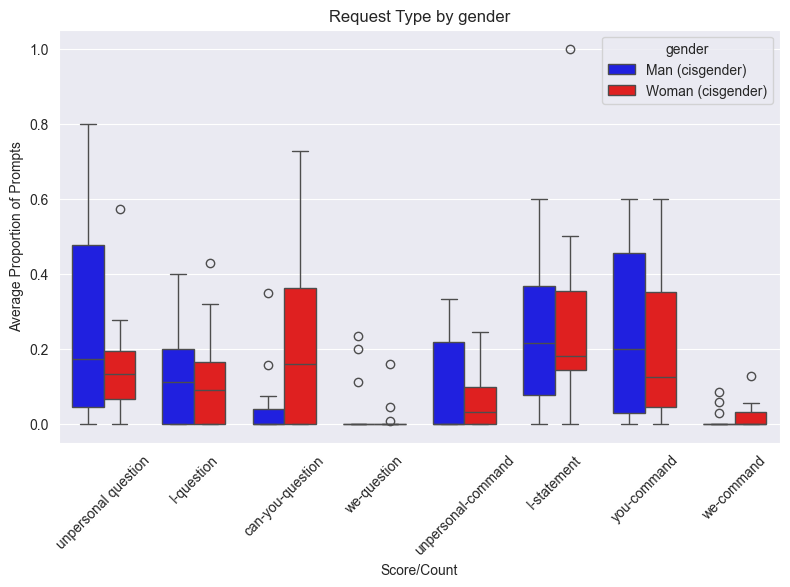

In [8]:
request_column_x_labels = [
    "unpersonal question",
    "I-question",
    "can-you-question",
    "we-question",
    "unpersonal-command",
    "I-statement",
    "you-command",
    "we-command",
]

box_plot(user_means, ['user_id', 'gender'], request_columns, request_column_x_labels, 'Prompt Type', 'Normalized Rate (per number of prompts)', 'gender', gender_palette)

In [9]:
from helpers.make_latex_table import create_latex_tables

rq_types_overall_results = groupwise_comparison_with_correction(user_means, request_columns).sort_values(by="p_value", ascending=True)
create_latex_tables(rq_types_overall_results, "request_types_stats.tex", "request_types_effsize.tex")

rq_types_overall_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
2,can_you_question,Mann-Whitney U,greater,False,None,49.0,0.018120,0.144960,0.160000,0.000000,0.230680,0.095715,13.0,15.0,9,5,-0.497436,RBC,"[-0.83, -0.13]"
7,we_command,Fisher's exact,greater,False,None,2.5,0.255072,0.962378,NaN,NaN,NaN,NaN,NaN,NaN,5,3,2.500000,Odds ratio,None
0,unpersonal_question,Mann-Whitney U,greater,False,None,114.5,0.444452,0.962378,0.132479,0.172840,0.150329,0.285802,13.0,15.0,11,11,0.174359,RBC,"[-0.32, 0.54]"
3,we_question,Fisher's exact,greater,False,None,1.2,0.600483,0.962378,NaN,NaN,NaN,NaN,NaN,NaN,3,3,1.200000,Odds ratio,None
6,you_command,Mann-Whitney U,greater,False,None,105.5,0.727277,0.962378,0.125000,0.200000,0.214719,0.215160,13.0,15.0,10,11,0.082051,RBC,"[-0.33, 0.53]"
4,unpersonal_command,Mann-Whitney U,greater,False,None,104.5,0.752304,0.962378,0.032258,0.000000,0.076668,0.128813,13.0,15.0,8,7,0.071795,RBC,"[-0.37, 0.47]"
5,i_statement,Mann-Whitney U,greater,False,None,95.5,0.944806,0.962378,0.181818,0.215686,0.259102,0.186729,13.0,15.0,12,12,-0.020513,RBC,"[-0.43, 0.43]"
1,i_question,Mann-Whitney U,greater,False,None,99.0,0.962378,0.962378,0.089744,0.111111,0.136125,0.130542,13.0,15.0,9,9,0.015385,RBC,"[-0.4, 0.46]"


## Directness & Indirectness

"Directness": [
        "unpersonal_command", "unpersonal_question",
        "you_command", "i_statement", "we_command"
    ],
"Indirectness": ["can_you_question", "we_question", "i_question"]

In [10]:
user_means['directness'] = user_means[[
        "unpersonal_command",
        "you_command", "i_statement", "we_command", "unpersonal_question"
    ]].mean(axis=1)
user_means['indirectness'] = user_means[["can_you_question", "we_question", "i_question", ]].mean(axis=1)

# Now, compute average for each user
directness_means = user_means.groupby(['gender'])[['directness', 'indirectness']].mean().reset_index()

directness_means


,gender,directness,indirectness
0,Man (cisgender),0.174833,0.067845
1,Woman (cisgender),0.148491,0.118623


In [11]:
results = groupwise_comparison_with_correction(user_means, ['directness', 'indirectness'])
results


,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,directness,T-test,two-sided,False,22.289378,1.203365,0.241461,0.241461,0.148491,0.174833,0.064361,0.049076,13,15,13,15,0.465043,Cohen's d,"[-0.3, 1.37]"
1,indirectness,T-test,two-sided,False,22.560825,-1.903943,0.069750,0.139499,0.118623,0.067845,0.077893,0.060566,13,15,11,10,-0.734785,Cohen's d,"[-1.53, 0.14]"


In [12]:
box_plot(
    user_means,
    id_vars=['user_id', 'gender'],                   # these are not used for y axis
    bar_variables=['directness', 'indirectness'],    # plot both categories
    x_label='Category',
    y_label='Mean Score',
    hue_variable='gender',
    palette=gender_palette
)


TypeError: box_plot() missing 1 required positional argument: 'x_tick_labels'